LGBMをOptunaでチューニング... 
fExp上位(=fImp上位)のFeatureを順に削っていき順次モデル作成


In [1]:
import seaborn as sns
import csv
import optuna
import optuna.integration.lightgbm as lgb
import itertools, logging, joblib
from sklearn.model_selection import train_test_split
NOTE_NAME = "lgbm2"

In [2]:
ROUND = "238"
TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"
N_FEATURE = 310
N_MODEL = 8

In [16]:
# signal
signals = pd.read_csv(f"{NOTE_NAME}/lgbm2_signals_train.csv", index_col=["id"])
val_signals = pd.read_csv(f"{NOTE_NAME}/lgbm2_signals_val.csv", index_col=["id"])

/home/tarai/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
signals.head(1)

,0,1,2,3,4,5,6,7,era,target,eraNum
id,,,,,,,,,,,
n000315175b67977,0.49238,0.497202,0.495247,0.495192,0.49639,0.502217,0.501421,0.500243,era1,0.5,1


In [7]:
# set logger
logger = logging.getLogger()  # root logger
fh = logging.FileHandler(f'{NOTE_NAME}/train2.log')
fh.setFormatter(logging.Formatter('%(asctime)s|%(message)s', '%Y-%m-%d %H:%M:%S'))
logger.addHandler(fh)

optuna.logging.enable_propagation()  # Propagate logs to the root logger.
optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

In [8]:
# test/train split
cols_feature = [str(i) for i in range(N_MODEL)]
_train, _val = train_test_split(signals.loc[:, cols_feature+[TARGET_NAME]], train_size=0.9, random_state=1)

In [10]:
# set train data
train_lgb = lgb.Dataset(_train.loc[:, cols_feature], label=_train[TARGET_NAME])
val_lgb = lgb.Dataset(_val.loc[:, cols_feature], label=_val[TARGET_NAME])

## fit setting 
default_params = {
    'objective': 'regression',
    'metric': 'l2',
    'random_state': 1
}

model = lgb.LightGBMTuner(
    default_params, train_lgb, valid_sets=val_lgb, early_stopping_rounds=40,
    time_budget=3600*24, verbose_eval=False
)

# fit
model.run()

# save
joblib.dump(model.best_booster, f"{NOTE_NAME}/ensemble_lgb.pkl")

min_data_in_leaf, val_score: 0.049385: 100%|##########| 5/5 [00:02<00:00,  2.37it/s]
/home/tarai/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: best_booster has been deprecated in v1.4.0. This feature will be removed in v3.0.0.


['lgbm2/ensemble_lgb.pkl']

---

In [11]:
model.best_params

{'objective': 'regression',
 'metric': 'l2',
 'random_state': 1,
 'feature_pre_filter': False,
 'lambda_l1': 1.4109422037253559e-05,
 'lambda_l2': 0.01539485038637797,
 'num_leaves': 27,
 'feature_fraction': 0.5479999999999999,
 'bagging_fraction': 0.825354070883797,
 'bagging_freq': 3,
 'min_child_samples': 100}

In [7]:
model = joblib.load(f"{NOTE_NAME}/ensemble_lgb.pkl")

In [19]:
signals2 = pd.DataFrame(model.predict(signals.iloc[:, :N_MODEL]), index=signals.index,
                        columns=["pred"]).join(signals[["era", "target"]])
# signals2.to_csv(f"{NOTE_NAME}/ensemble_pred.csv")

In [20]:
val_signals2 = pd.DataFrame(model.predict(val_signals.iloc[:, :N_MODEL]), index=val_signals.index,
                            columns=["pred"]).join(val_signals[["era", "target"]])
# val_signals2.to_csv(f"{NOTE_NAME}/ensemble_pred_val.csv")

---  
### Eval

#### CORR

In [14]:
# Submissions are scored by spearman correlation
def calcRankCorr(i):
    def _main(df):
        ranked_preds = df[i].rank(pct=True, method="first")
        return np.corrcoef(ranked_preds, df[TARGET_NAME])[0, 1]
    return _main

In [21]:
# era毎にcorr計算
corr = signals2.groupby("era").apply(calcRankCorr("pred"))
val_corr = val_signals2.groupby("era").apply(calcRankCorr("pred"))

In [22]:
# in sample score
corr.agg(["mean", "std", lambda x: x.mean()/x.std()]).to_frame()

,0
mean,0.142386
std,0.025752
<lambda>,5.529101


In [23]:
# validation sample score
val_corr.agg(["mean", "std", lambda x: x.mean()/x.std()]).to_frame()

,0
mean,0.017094
std,0.020127
<lambda>,0.849268


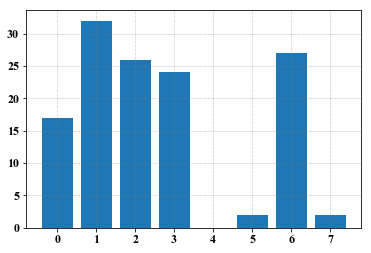

In [13]:
plt.bar(model.feature_name(), model.feature_importance());

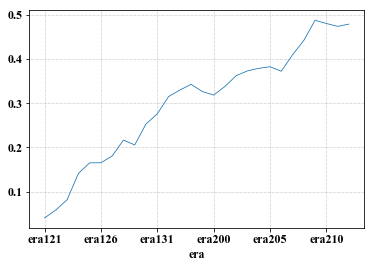

In [26]:
val_corr.cumsum().plot()